# [Source](https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()
import os
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
ollama_model = os.getenv("ollama_model")

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
#llm = init_chat_model(f"ollama:{ollama_model}")
llm = ChatOllama(
    model=ollama_model,
    reasoning=True
)

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [7]:
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
checkpointer = InMemorySaver()

In [11]:
cfg = {"configurable": {"thread_id": "1"}}

In [12]:
graph = graph_builder.compile(checkpointer=checkpointer)

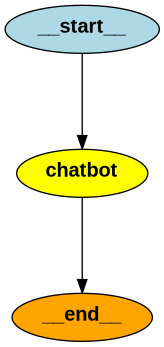

In [13]:
g = graph.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [14]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, cfg):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [15]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! 👋 How can I help you today?
Assistant: I’m ChatGPT—your AI assistant. How can I help you today?
Assistant: 1 + 1 = 2.
Assistant: The answer was **2**.
Assistant: Thanks! 😊 What else can I help you with today?
Goodbye!
